# **Cassava Leaf Disease Classification**

This case study is on the Kaggle competition  "Cassava Leaf Disease Classification" .Identify the type of disease present in Cassava Leaf image.


This is Computer Vision Problem where we have to try different Computer Vision models. Then design architecture to ensemble them.

The aim of this case study is to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers.

# **Data Set**


Files:

[train/test]_images     - the image files.

[train/test]_tfrecords  - the image files in tfrecord format.

Roughly 15,000 images in the test set.

train.csv:

image_id - the image file name.

label    - the ID code for the disease.

label_num_to_disease_map.json - The mapping between each disease code and the real disease name.

# **1. Reading Data**

## **1.1 Loading Data**

In [101]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")
cwd = os.getcwd()
print(cwd)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [102]:
!pip install fastai --upgrade

In [103]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
from fastai.vision.all import *
from fastai import *

set_seed(19)

In [105]:
cassava_data_find = Path('cassava-leaf-disease-classification')
cassava_data_find.ls()

(#8) [Path('cassava-leaf-disease-classification/test_images'),Path('cassava-leaf-disease-classification/test_tfrecords'),Path('cassava-leaf-disease-classification/train_images'),Path('cassava-leaf-disease-classification/train_tfrecords'),Path('cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('cassava-leaf-disease-classification/sample_submission.csv'),Path('cassava-leaf-disease-classification/train.csv'),Path('cassava-leaf-disease-classification/Case_Study_2 Cassava_leaf_disease_classification.ipynb')]

In [107]:
cassava_data = pd.read_csv(cassava_data_find/"train.csv")
cassava_data['image_id'] = cassava_data['image_id'].apply(lambda i: f'train_images/{i}')

In [108]:
cassava_data.head(5)

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3


In [109]:
cassava_data.shape

(21397, 2)

In [111]:
submission = pd.read_csv(cassava_data_find/'sample_submission.csv') 
submission_final = submission.copy() 
submission_final.head()

,image_id,label
0,2216849948.jpg,4


In [112]:
submission_final['image_id'] = 'test_images/' + submission_final['image_id'] 

In [113]:
submission_final.head()

,image_id,label
0,test_images/2216849948.jpg,4


## **1.2 Checking for null values**

In [114]:
# checking for null values in cassava_data

print(cassava_data.isnull().any())

image_id    False
label       False
dtype: bool


No null values found

## **1.3 Checking for outliers**

We are using percentile approach to determine outliers

In [115]:
Q0 = cassava_data.quantile(0)
Q1 = cassava_data.quantile(.01)
Q50 = cassava_data.quantile(.5)
Q99 = cassava_data.quantile(.99)
Q100= cassava_data.quantile(1)

In [116]:
#range of values for label column.We are checking 0th and 100th percentile values here.
print(Q0[0],Q100[0])

0.0 4.0


Label values should range from 0-4.No outlier in store column

# **2. EDA**

## **2.1 Histogram of label column**

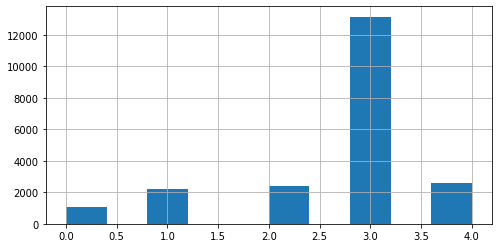

In [117]:
cassava_data['label'].hist(figsize = (8, 4))

There are 5 labels:

0:Cassava Bacterial Blight (CBB)

1:Cassava Brown Streak Disease (CBSD)

2:Cassava Green Mottle (CGM)

3:Cassava Mosaic Disease (CMD)

4:Healthy

The most common label is 3

## **2.2 Image Size**

In [119]:
from PIL import Image as I

cassava_image_size = I.open('cassava-leaf-disease-classification/'+ cassava_data['image_id'][1])
cassava_image_width, cassava_image_height = cassava_data_image_size.size
print(cassava_image_width,cassava_image_height) 

800 600


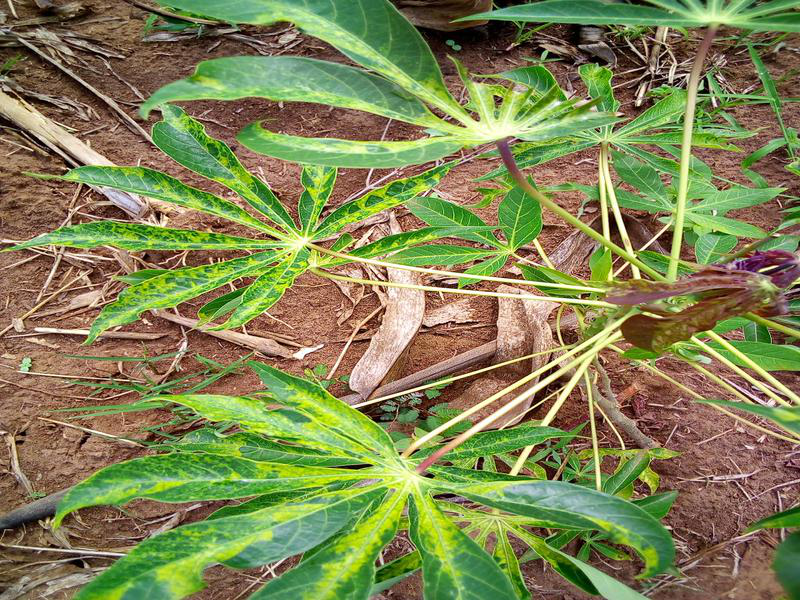

In [120]:
cassava_image_size

# **3. Model Loading and Inference**

In [121]:
def parent_value(cassava_image_value):
    return cassava_data_find/cassava_image_value['image_id']

def parent_label(cassava_image_label):
    return cassava_image_label['label']

In [122]:
Cassava_Data_Build = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_x = parent_value,
    get_y = parent_label,
    item_tfms = Resize(448),
    batch_tfms = [RandomResizedCropGPU(224), *aug_transforms(), Normalize.from_stats(*imagenet_stats)] 
)

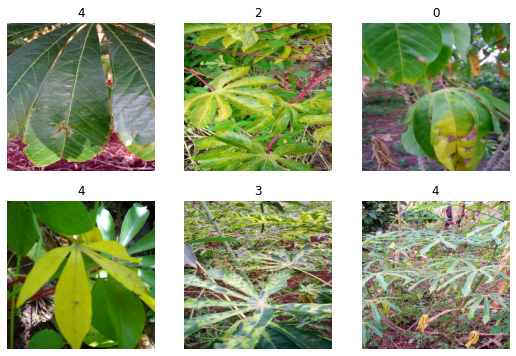

In [123]:
cassava_data_loaders = Cassava_Data_Build.dataloaders(cassava_data, batch_size=64)
cassava_data_loaders.valid.show_batch(max_n=6, nrows=2)

In [124]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')

In [134]:
cassava_data_cnn = cnn_learner(cassava_data_loaders, resnet50, metrics=accuracy, loss_func = LabelSmoothingCrossEntropy(),opt_func = ranger)
cassava_data_cnn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.505111,1.343465,0.614630,03:35


epoch,train_loss,valid_loss,accuracy,time
0,1.158147,0.980651,0.724702,03:49
1,1.014250,0.925799,0.775181,03:40
2,0.888380,0.870904,0.781024,03:40
3,0.808225,0.805717,0.806497,03:40
4,0.767912,0.778809,0.817714,03:38
5,0.725803,0.733634,0.833372,03:42
6,0.711440,0.752372,0.826361,03:45
7,0.684168,0.733811,0.834073,03:43
8,0.671703,0.740716,0.831269,03:42
9,0.666973,0.734390,0.833139,03:36


# **4. Model Testing**

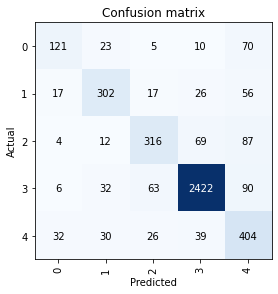

In [135]:
#confusion matrix
cassava_data_confusion = ClassificationInterpretation.from_learner(cassava_data_cnn)
cassava_data_confusion.plot_confusion_matrix()

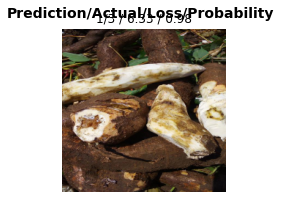

In [142]:
cassava_data_confusion.plot_top_losses(1)

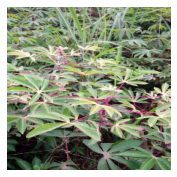

In [137]:
cassava_data_learn_dl = cassava_data_loaders.test_dl(submission_final) 
cassava_data_learn_dl.show_batch()

In [138]:
cassava_data_cnn_preds = cassava_data_cnn.tta(dl=cassava_data_learn_dl, n=8, beta=0) 

In [139]:
submission['label'] = np.argmax(cassava_data_cnn_preds[0], axis=1) 

In [140]:
submission.head()

,image_id,label
0,2216849948.jpg,2


In [141]:
submission.to_csv('submission.csv', index=False) 